* load LME chunked by box quasi-LME EN4 profile data 
* Load LME mask to exclude unwanted profiles
* Selected nearest NEMO point in space and time using pre-calculated indices (for a more general approach could otherwise do with profile.obs_operator)

conda env: base

conda create -n senemo-profile-lme python=3.10 numpy xarray matplotlib scipy jupyter netCDF4

source activate senemo-profile-lme
jupyter notebook --no-browser --port=8822


jelt: 7 Mar 2024

In [1]:
import numpy as np
import xarray as xr
import netCDF4
import matplotlib.pyplot as plt
import scipy

In [2]:
%cd /login/jelt/GitHub/SE-NEMO/scripts/analysis/Notebooks

/vkamino/work/jelt/GitHub/SE-NEMO/scripts/analysis/Notebooks


/work/jelt/conda-env/senemo-profile-lme/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
# Load LME mask on the ORCA025 grid
# in https://github.com/NOC-MSM/SE-NEMO/blob/analysis-jholt/scripts/analysis/Data/ORCA025_ROAM_GLB_LMEmaskV4.mat

a=scipy.io.loadmat('../Data/ORCA025_ROAM_GLB_LMEmaskV4.mat')
LME_mask=a['LME_mask'][:,:].T

# NB indices are on old ORCA grid so need to offset J index for eORCA grid
J_offset=186 #account for extra rows in eORCA if data is made for normal ORCA

In [4]:
LME_mask.shape

(1021, 1442)

In [5]:
eLME_mask = np.vstack([ np.nan*np.zeros((J_offset, LME_mask.shape[1] )),  LME_mask])  # Add the extra latitude rows

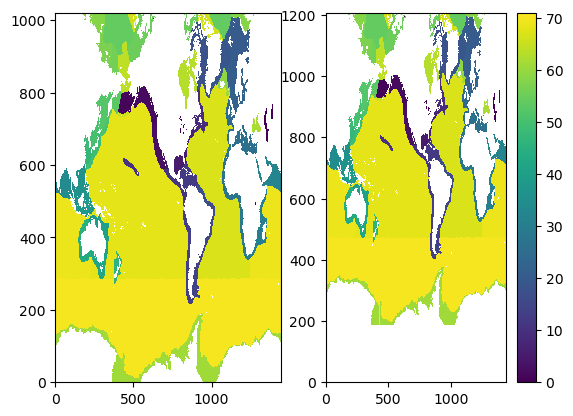

In [6]:
plt.subplot(1,2,1)
plt.pcolormesh(LME_mask)

plt.subplot(1,2,2)
plt.pcolormesh(eLME_mask)
plt.colorbar(orientation='vertical')
plt.show()

In [7]:
# Load the EN4 data by approx LME
LME_en4_in_dir = "/projectsa/NEMO/jholt/SE-NEMO/ASSESSMENT/EN4.2.1/1978-2019/"
LME_en4_out_dir = "/projectsa/NEMO/jelt/SE-NEMO/ASSESSMENT/EN4.2.1/1978-2019/"
LME_Data=np.load('../Data/LME_gridinfo_V4.npz')
#en4_path='/projectsa/NEMO/OBS/EN4.2.1/'
#en4_name='EN.4.2.1.f.profiles.l09.'

In [8]:
"""
Want preprocesses EN4 data onto the model space time grid.
* resample over time intervals (1MS)
* average colocated data in time interval

groupby_multicoords(da=dd_clean, fields=['ind_x', 'ind_y']).apply(grid_time_mean)
--> dims: time, grouping_zip
where grouping_zip are unqiue coordinate tuples

Then need to flatten and reconstruct DataSet and drop nans
"""
def groupby_multicoords(da, fields):
    common_dim = da.coords[fields[0]].dims[0]
    tups_arr = np.empty(len(da[common_dim]), dtype=object)
    tups_arr[:] = list(zip(*(da[f].values for f in fields)))
    return da.assign_coords(grouping_zip=xr.DataArray(tups_arr, dims=common_dim)).groupby('grouping_zip')

def grid_time_mean(x):
    return x.resample(time="1MS").mean()

ystart = 1978
ystop = 2019
nLME = LME_Data["DOMNAM"].shape[0]
#for iLME in range(21,22): #66):
for iLME in range(66):
    LME_Name=LME_Data["DOMNAM"][iLME]

    fname='{0}/{1}_{2}_{3}_EN4_PEA_SST_SSS_v1.nc'.format(LME_en4_in_dir, LME_Name,ystart,ystop)
    try:
        dd = xr.open_dataset(fname)
        dd = dd.isel(id_dim = dd.ind_good) # only keep Good profiles
    
        # indices of nearest grid boxes are sorted by distance in ind_x, ind_y. So take the first values
        #  Is dd.ind_x, dd.ind_y in the LME?
        JJ, II = dd.isel(NNs=0).ind_y, dd.isel(NNs=0).ind_x
        flag_in_lme = eLME_mask[JJ,II] == iLME+1  # values in mask need shifting
        
        # only retain profile in the LME and rename dimension
        dd_clean = dd.isel(Ngood=flag_in_lme).rename_dims({'Ngood':'id_dim'})
        
        # only retain the closest indices
        dd_clean = dd_clean.isel(NNs=0).drop_vars(["ind_good", "rmin_prf", "ind_x_min", "ind_y_min"])
    
        dd_clean['lat'] = dd_clean.latitude  # make as variable, as coords gets lost in averaging
        dd_clean['lon'] = dd_clean.longitude
        dd_clean['ind_i'] = dd_clean.ind_x
        dd_clean['ind_j'] = dd_clean.ind_y
        
        dd_clean = dd_clean.sortby(dd_clean.time)  # Sort by time
        
        if dd_clean.dims['id_dim'] > 0:
                
            dd_clean = dd_clean.set_coords(["ind_x", "ind_y"])  # so that groupby_multicoords() works
            dd_gridded = groupby_multicoords(da=dd_clean, fields=['ind_x', 'ind_y']).apply(grid_time_mean)  # returns a gridded [coord_tuple, time] object
            dd_gridded["time"] = dd_gridded.time + np.timedelta64(14,'D')  # Offset the time to be middle of the month, not 1st (the default)
            #print(dd_new)
    
            # Expand (grouping_zip, time) into id_dim
            time_mon = dd_gridded.time.expand_dims(dim={"grouping_zip": dd_gridded.dims['grouping_zip']}).values.flatten()
    
            # Rebuild dataset as a Profile object
            da_pea = xr.DataArray(data=dd_gridded.pea.values.flatten(),
                      coords={"time": (["id_dim"], time_mon)}, dims=["id_dim"])
            
            da_sst = xr.DataArray(data=dd_gridded.sst.values.flatten(),
                      coords={"time": (["id_dim"], time_mon)}, dims=["id_dim"])
            
            da_sss = xr.DataArray(data=dd_gridded.sss.values.flatten(),
                      coords={"time": (["id_dim"], time_mon)}, dims=["id_dim"])
            
            da_lat = xr.DataArray(data=dd_gridded.lat.values.flatten(),
                      coords={"time": (["id_dim"], time_mon)}, dims=["id_dim"])
            
            da_lon = xr.DataArray(data=dd_gridded.lon.values.flatten(),
                      coords={"time": (["id_dim"], time_mon)}, dims=["id_dim"])
            
            da_i = xr.DataArray(data=dd_gridded.ind_i.values.flatten(),
                      coords={"time": (["id_dim"], time_mon)}, dims=["id_dim"])
            
            da_j = xr.DataArray(data=dd_gridded.ind_j.values.flatten(),
                      coords={"time": (["id_dim"], time_mon)}, dims=["id_dim"])
            
            ds = xr.Dataset({"pea": da_pea, "sst": da_sst, "sss": da_sss,
                             "latitude": da_lat, "longitude": da_lon,
                             "ind_i": da_i, "ind_j": da_j})
    
            ds = ds.dropna(dim="id_dim")
            ds = ds.set_coords(["latitude", "longitude"])
            
            # Print number of profiles before and after averaging
            print(f'{LME_Name}: size {dd.dims["Ngood"]} --> {ds.dims["id_dim"]}')
            # Save to netcdf
            fname='{0}/{1}_{2}_{3}_EN4_PEA_SST_SSS_binned.nc'.format(LME_en4_out_dir, LME_Name,ystart,ystop)
            ds.to_netcdf(fname)
        else:
            print(LME_Name)
    except:
        pass


East_Bering_Sea_01: size 43816 --> 12510
Gulf_of_Alaska_02: size 429469 --> 34681
California_Current_03: size 398114 --> 33228
Gulf_of_California_04: size 3835 --> 261
Gulf_of_Mexico_05: size 189949 --> 14265
Southeast_U.S._Continental_Shelf_06: size 35476 --> 2146
Northeast_U.S._Continental_Shelf_07: size 619361 --> 36147
Scotian_Shelf_08: size 94878 --> 17641
Labrador_-_Newfoundland_09: size 437543 --> 51810
Insular_Pacific-Hawaiian_10: size 77605 --> 6180
Pacific_Central-American_Coastal_11: size 213425 --> 3771
Caribbean_Sea_12: size 186126 --> 6813
Humboldt_Current_13: size 48959 --> 12782
Patagonian_Shelf_14: size 36065 --> 6976
South_Brazil_Shelf_15: size 13653 --> 1813
East_Brazil_Shelf_16: size 35068 --> 3556
North_Brazil_Shelf_17: size 24753 --> 2421
Canadian_Eastern_Arctic_-_West_Greenland_18: size 31316 --> 9736
Greenland_Sea_19: size 210909 --> 17576
Barents_Sea_20: size 224336 --> 66174
Norwegian_Sea_21: size 110679 --> 44354
North_Sea_22: size 236974 --> 58601
Baltic_Sea

In [9]:
dd.dims["Ngood"]

10750

In [34]:
LME_en4_out_dir

'/projectsa/NEMO/jelt/SE-NEMO/ASSESSMENT/EN4.2.1/1978-2019/'

In [10]:
eLME_mask[np.isfinite(eLME_mask)].max()

71.0

In [22]:
iLME = 66

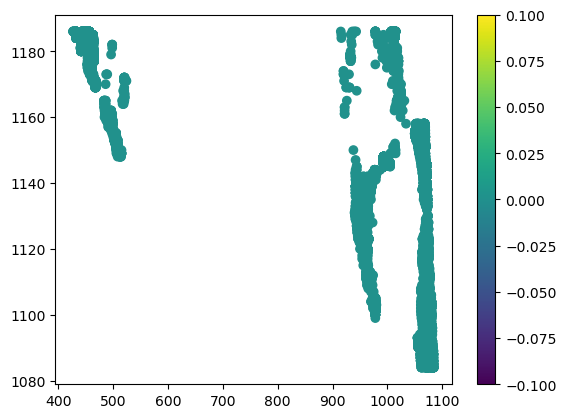

In [23]:
plt.scatter( II, JJ, c=eLME_mask[JJ,II]==iLME+1)
plt.colorbar()

Text(0.5, 0.98, 'Canadian_High_Arctic_-_North_Greenland_66')

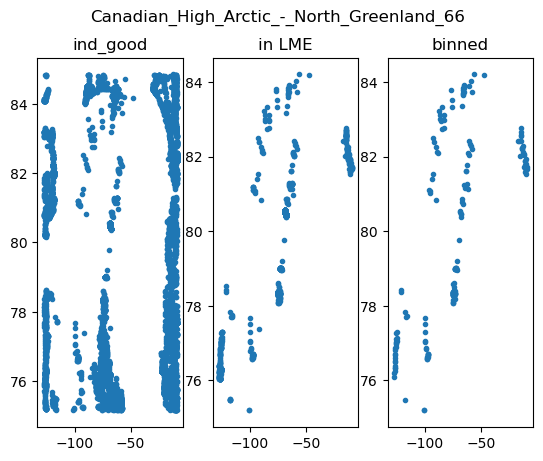

In [24]:
# Compare distribution of original profile set, cleaned set, and rebinned set.
plt.subplot(1,3,1)
plt.plot( dd.longitude, dd.latitude, '.'); plt.title("ind_good")
plt.subplot(1,3,2)
plt.plot( dd_clean.longitude, dd_clean.latitude, '.'); plt.title("in LME")
plt.subplot(1,3,3)
plt.plot( ds.longitude, ds.latitude, '.'); plt.title("binned")
plt.suptitle(LME_Name)

Text(0.5, 1.0, 'LME mask in ORCA grid')

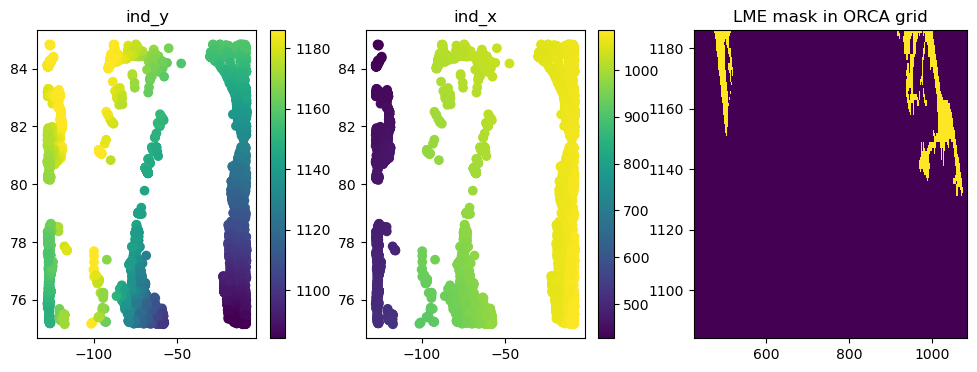

In [30]:
# Show ORCA grid indices stored in the EN4 proceeded data are where they are expected

plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.scatter( dd.longitude, dd.latitude, c=dd.isel(NNs=0).ind_y)
plt.title("ind_y")
plt.colorbar()

plt.subplot(1,3,2)
plt.scatter( dd.longitude, dd.latitude, c=dd.isel(NNs=0).ind_x)
plt.title("ind_x")
plt.colorbar()

plt.subplot(1,3,3)
plt.pcolormesh((eLME_mask >= iLME-1) & (eLME_mask <= iLME+1))
plt.xlim([dd.isel(NNs=0).ind_x.min(), dd.isel(NNs=0).ind_x.max()])
plt.ylim([dd.isel(NNs=0).ind_y.min(), dd.isel(NNs=0).ind_y.max()])
plt.title('LME mask in ORCA grid')

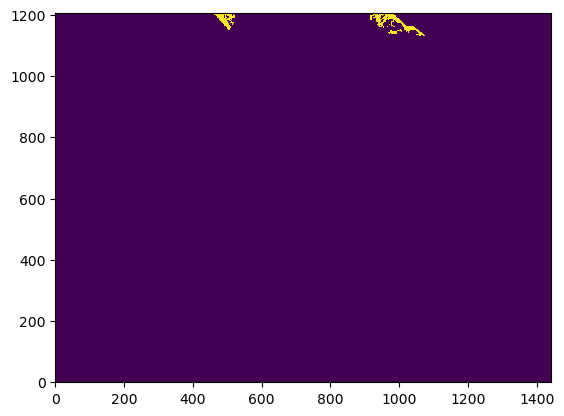

In [32]:
plt.pcolormesh((eLME_mask >= iLME) & (eLME_mask <= iLME))
#plt.xlim([dd.isel(NNs=0).ind_x.min(), dd.isel(NNs=0).ind_x.max()])
#plt.ylim([dd.isel(NNs=0).ind_y.min(), dd.isel(NNs=0).ind_y.max()])

Text(0.5, 1.0, 'Canadian_High_Arctic_-_North_Greenland_66')

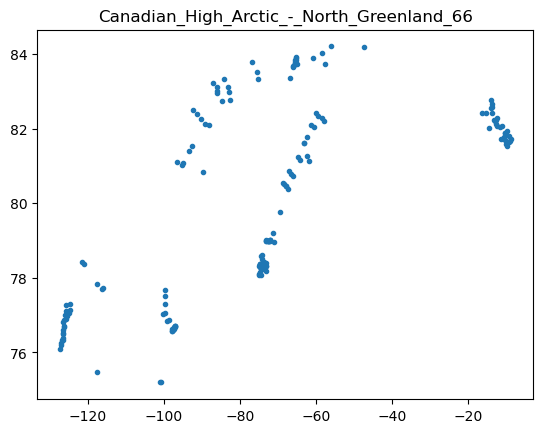

In [15]:
plt.plot( ds.longitude, ds.latitude, '.'); plt.title(LME_Name)

In [141]:
import xarray as xr

d = xr.DataArray([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12], [13, 14, 15]],
    coords={
        'a': ('dim1',['A', 'A', 'B', 'B', 'A']),
        'b': ('dim1',['1', '2', '1', '2', '1']),
        'c': ('dim2',['x', 'y', 'z'])
    },
    dims=['dim1', 'dim2'])

def groupby_multicoords(da, fields):
    common_dim = da.coords[fields[0]].dims[0]
    tups_arr = np.empty(len(da[common_dim]), dtype=object)
    tups_arr[:] = list(zip(*(da[f].values for f in fields)))
    return da.assign_coords(grouping_zip=xr.DataArray(tups_arr, dims=common_dim)).groupby('grouping_zip')


In [142]:
# d.groupby(['a','b']) # this gives: TypeError: `group` must be an xarray.DataArray or the name of an xarray variable or dimension

In [143]:
groupby_multicoords(da=d, fields=['a', 'b']).groups

{('A', '1'): [0, 4], ('A', '2'): [1], ('B', '1'): [2], ('B', '2'): [3]}

In [139]:
d

<xarray.DataArray (dim1: 5, dim2: 3)>
array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12],
       [13, 14, 15]])
Coordinates:
    a        (dim1) <U1 'A' 'A' 'B' 'B' 'A'
    b        (dim1) <U1 '1' '2' '1' '2' '1'
    c        (dim2) <U1 'x' 'y' 'z'
Dimensions without coordinates: dim1, dim2

In [140]:
groupby_multicoords(da=d, fields=['a', 'b']).mean()

<xarray.DataArray (grouping_zip: 4, dim2: 3)>
array([[ 7.,  8.,  9.],
       [ 4.,  5.,  6.],
       [ 7.,  8.,  9.],
       [10., 11., 12.]])
Coordinates:
    c             (dim2) <U1 'x' 'y' 'z'
  * grouping_zip  (grouping_zip) object ('A', '1') ('A', '2') ... ('B', '2')
Dimensions without coordinates: dim2